# Reinforcement Learning - Policy Gradient

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2022/main/logo.jpg" style="float: left; width: 15%" />

[INF581-2022](https://moodle.polytechnique.fr/course/view.php?id=11954) Lab session #7

2019-2022 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2022/blob/main/lab7_rl3_reinforce_answers.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2022/main?filepath=lab7_rl3_reinforce_answers.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf581-2022/blob/main/lab7_rl3_reinforce_answers.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf581-2022/raw/main/lab7_rl3_reinforce_answers.ipynb)

**Notice**: this notebook requires the following libraries: OpenAI *Gym*, NumPy, Pandas, Seaborn and imageio.

You can install them with the following command (the next cells do this for you if you use the Google Colab environment):

``
pip install gym numpy pandas seaborn imageio
``

In [1]:
%matplotlib inline

import subprocess

try:
    from inf581 import *
except ModuleNotFoundError:
    process = subprocess.Popen("pip install inf581".split(), stdout=subprocess.PIPE)

    for line in process.stdout:
        print(line.decode().strip())

    from inf581 import *

from inf581.lab7 import *

import matplotlib.pyplot as plt

import gym
import numpy as np
import seaborn as sns

from IPython.display import Image   # To display GIF images in the notebook

$
\newcommand{\vs}[1]{\mathbf{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\mathbf{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\U{V}
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
%
\def\E{\mathbb{E}}
%\newcommand{transition}{T(s,a,s')}
%\newcommand{transitionfunc}{\mathcal{T}^a_{ss'}}
\newcommand{transitionfunc}{P}
\newcommand{transitionfuncinst}{P(\nextstate|\state,\action)}
\newcommand{transitionfuncpi}{\mathcal{T}^{\pi_i(s)}_{ss'}}
\newcommand{rewardfunc}{r}
\newcommand{rewardfuncinst}{r(\state,\action,\nextstate)}
\newcommand{rewardfuncpi}{r(s,\pi_i(s),s')}
\newcommand{statespace}{\mathcal{S}}
\newcommand{statespaceterm}{\mathcal{S}^F}
\newcommand{statespacefull}{\mathcal{S^+}}
\newcommand{actionspace}{\mathcal{A}}
\newcommand{reward}{R}
\newcommand{statet}{S}
\newcommand{actiont}{A}
\newcommand{newstatet}{S'}
\newcommand{nextstate}{\state'}
\newcommand{newactiont}{A'}
\newcommand{stepsize}{\alpha}
\newcommand{discount}{\gamma}
\newcommand{qtable}{Q}
\newcommand{finalstate}{\state_F}
%
\newcommand{\vs}[1]{\boldsymbol{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\boldsymbol{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\vit{Value Iteration}
\def\pit{Policy Iteration}
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
\def\cstateset{\mathcal{X}} %%%
\def\x{\vs{x}}                    % TODO cstate
\def\cstate{\vs{x}}               %%%
\def\policy{\pi}
\def\piparam{\vs{\theta}}         % TODO pparam
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\caction{\vs{u}}       % action
\def\cactionset{\mathcal{U}} %%%
\def\decision{\vs{d}}       % decision
\def\randvar{\vs{\omega}}       %%%
\def\randset{\Omega}       %%%
\def\transition{T}       %%%
\def\immediatereward{r}    %%%
\def\strategichorizon{s}    %%% % TODO
\def\tacticalhorizon{k}    %%%  % TODO
\def\operationalhorizon{h}    %%%
\def\constalpha{a}    %%%
\def\U{V}              % utility function
\def\valuefunc{V}
\def\X{\mathcal{X}}
\def\meu{Maximum Expected Utility}
\def\finaltime{T}
\def\timeindex{t}
\def\iterationindex{i}
\def\decisionfunc{d}       % action
\def\mdp{\text{MDP}}
$

## Introduction

In a previous lab, we have dealt with reinforcement learning in discrete state and action spaces.
To do so, we used methods based on action-value function and, especially, $Q$-function estimation.
The $Q$-function was stored in a table and updated with on- or off- policy algorithms (namely SARSA and $Q$-Learning). 

Yet, these methods do not scale to large state spaces and especially not to the case of continuous state spaces.
To address these issues one can either extend value-based methods making use of value-function approximation or directly search in policy spaces.
In this lab, we will explore the second solution. 

More specifically, we will search in a family of parameterized policies $\pi_\theta(s, a)$ using a policy gradient method.
This method performs gradient ascent in the policy space so that the total return is maximized.
We will restrict our work to episodic tasks, *i.e.* tasks that have a starting states and last for a finite and fixed number of steps $H$, called horizon. 

More formally, we define an optimization criterion that we want to maximize:

$$J(\theta) = \E_{\pi_\theta}\left[\sum_{t=1}^H r(s_t,a_t)\right],$$

where $\E_{\pi_\theta}$ means $a \sim \pi_\theta(s,.)$ and $H$ is the horizon of the episode.
In other words, we want to maximize the value of the starting state: $V^{\pi_\theta}(s)$.
The policy gradient theorem tells us that:

$$
\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \E_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (s,a) ~ Q^{\pi_\theta}(s,a) \right],
$$
With 

$$Q^\pi(s,a) = \E^\pi \left[\sum_{t=1}^H r(s_t,a_t)|s=s_1, a=a_1\right].$$

Policy Gradient theorem is extremely powerful because it says one doesn't need to know the dynamics of the system to compute the gradient if one can compute the $Q$-function of the current policy.
By applying the policy and observing the one-step transitions is enough.
Using a stochastic gradient ascent and replacing $Q^{\pi_\theta}(s_t,a_t)$ by a Monte Carlo estimate $R_t = \sum_{t'=t}^H r(s_{t'},a_{t'})$ over one single trajectory, we end up with a special case of the REINFORCE algorithm (see Algorithm below). 

---
REINFORCE with Policy Gradient theorem Algorithm
---

Initialize $\theta^0$ as random<br>
Initialize step-size $\alpha_0$<br>
$n \leftarrow 0$<br>
<b>WHILE</b> no convergence<br>
	$\quad$ Generate rollout $h_n \leftarrow \{s_1^n,a_1^n,r_1^n, \ldots, s_H^n, a_H^n, r_H^n\} \sim \pi_{\theta^n}$<br>
	$\quad$ $PG_\theta \leftarrow 0$<br>
	$\quad$ <b>FOR</b> $t=1$ to $H$<br>
		$\quad\quad$ $R_t \leftarrow \sum_{t'=t}^H r_{t'}^n$<br>
		$\quad\quad$ $PG_\theta \leftarrow PG_\theta + \nabla_\theta \log \pi_{\theta^{n}}(s_t,a_t) ~ R_t$<br>
	$\quad$ $n \leftarrow n + 1$ <br>
	$\quad$ $\theta^n \leftarrow \theta^{n-1} + \alpha_n PG_\theta$<br>
	$\quad$  update $\alpha_n$ (if step-size scheduling)<br>

<b>RETURN</b> $\theta^n$ 

**Notice**: by replacing the $Q$-function by a Monte-Carlo estimate, we get rid of the Markov assumption and this algorithm is expected to work even in non-Markovian systems. 

For the purpose of focusing on the algorithms, we will use standard environments provided by OpenAI Gym suite.
OpenAI Gym provides controllable environments (https://gym.openai.com/envs/) for research in reinforcement learning.
Especially, we will try to solve the CartPole-v0 environment (c.f. https://gym.openai.com/envs/CartPole-v0/ and https://github.com/openai/gym/wiki/CartPole-v0) which offers a continuous state space and discrete action space.
The Cart Pole task consists in maintaining a pole in a vertical position by moving a cart on which the pole is attached with a joint.
No friction is considered.
The task is supposed to be solved if the pole stays up-right (within 15 degrees) for 195 steps in average over 100 episodes while keeping the cart position within reasonable bounds.
The state is given by $\{x,\frac{\partial x}{\partial t},\omega,\frac{\partial \omega}{\partial t}\}$ where $x$ is the position of the cart and $\omega$ is the angle between the pole and vertical position.
There are only two possible actions: $a \in \{0, 1\}$ where $a = 0$ means "push the cart to the LEFT" and $a = 1$ means "push the cart to the RIGHT".

## Exercise 1: Hands on Cart Pole

**Task 1:** read  https://gym.openai.com/envs/CartPole-v0/ and https://github.com/openai/gym/wiki/CartPole-v0 to discover the CartPole environment.

**Notice:** A reminder of Gym main concepts is available at https://gym.openai.com/docs/.

Print some information about the environment:

In [2]:
env = gym.make('CartPole-v0')
print("State space dimension is:", env.observation_space.shape[0])
print("State upper bounds:", env.observation_space.high)
print("State lower bounds:", env.observation_space.low)
print("Actions are: {" + ", ".join([str(a) for a in range(env.action_space.n)]) + "}")
env.close()

State space dimension is: 4
State upper bounds: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
State lower bounds: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Actions are: {0, 1}


**Task 2:** Run the following cells and check different basic 

policies (for instance constant actions or randomly drawn actions) to discover the CartPole environment.
Although this environment has easy dynamics that can be computed analytically, we will solve this problem with Policy Gradient based Reinforcement learning.

### Test the CartPole environment with a constant policy

[-0.00017517 -0.0199781   0.04839778  0.03838956]
[-0.00057473 -0.21575947  0.04916557  0.34594113]
[-0.00488992 -0.41154505  0.05608439  0.65371348]
[-0.01312082 -0.60740125  0.06915866  0.96351602]
[-0.02526885 -0.80338081  0.08842898  1.27709907]
[-0.04133646 -0.99951191  0.11397096  1.59611046]
[-0.0613267  -1.19578585  0.14589317  1.92204631]
[-0.08524242 -1.39214296  0.1843341   2.25619354]
xx

/home/jeremie/anaconda3/envs/psc/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


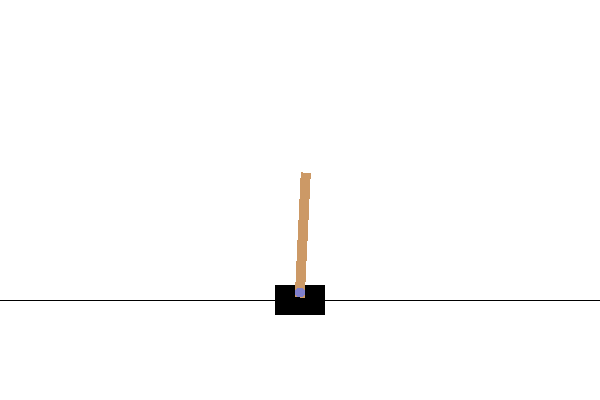

In [3]:
env = gym.make('CartPole-v0')
RenderWrapper.register(env, force_gif=True)

observation = env.reset()
done = False

for t in range(50):
    env.render_wrapper.render()

    if not done:
        print(observation)
    else:
        print("x", end="")

    ### BEGIN SOLUTION ###

    action = 0
    observation, reward, done, info = env.step(action)

    ### END SOLUTION ###


print()
env.close()

env.render_wrapper.make_gif("ex1left")

[-0.0115188  -0.00909509 -0.04727814  0.00911212]
[-0.0117007   0.18667189 -0.04709589 -0.29810482]
[-0.00796727  0.38243244 -0.05305799 -0.60526112]
[-3.18617619e-04  5.78254637e-01 -6.51632130e-02 -9.14172798e-01]
[ 0.01124648  0.7741946  -0.08344667 -1.22660338]
[ 0.02673037  0.97028572 -0.10797874 -1.54422143]
[ 0.04613608  1.16652675 -0.13886317 -1.86855269]
[ 0.06946662  1.36286795 -0.17623422 -2.20092422]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


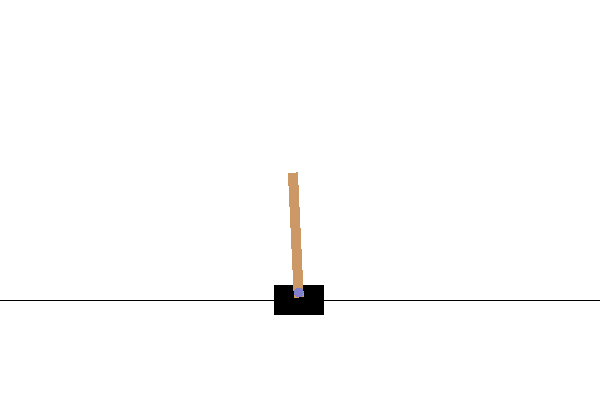

In [4]:
env = gym.make('CartPole-v0')
RenderWrapper.register(env, force_gif=True)

observation = env.reset()
done = False

for t in range(50):
    env.render_wrapper.render()

    if not done:
        print(observation)
    else:
        print("x", end="")

    ### BEGIN SOLUTION ###

    action = 1
    observation, reward, done, info = env.step(action)

    ### END SOLUTION ###

print()
env.close()

env.render_wrapper.make_gif("ex1right")

### Test the CartPole environment with a random policy

[-0.01088512  0.02634108 -0.01590603 -0.00631713]
[-0.0103583  -0.16854919 -0.01603238  0.28130512]
[-0.01372928 -0.36343882 -0.01040627  0.56888868]
[-0.02099806 -0.16817247  0.0009715   0.27294563]
[-0.02436151 -0.36330827  0.00643041  0.56593481]
[-0.03162767 -0.16827712  0.01774911  0.27528466]
[-0.03499322  0.02658715  0.0232548  -0.01174775]
[-0.03446147 -0.16886045  0.02301985  0.28818068]
[-0.03783868 -0.36430298  0.02878346  0.58803405]
[-0.04512474 -0.55981594  0.04054414  0.88964318]
[-0.05632106 -0.36526691  0.05833701  0.60997616]
[-0.0636264  -0.56115371  0.07053653  0.92044788]
[-0.07484947 -0.75715442  0.08894549  1.2344384 ]
[-0.08999256 -0.56328123  0.11363425  0.97089371]
[-0.10125819 -0.75972978  0.13305213  1.29700268]
[-0.11645278 -0.56652462  0.15899218  1.04875839]
[-0.12778327 -0.76335761  0.17996735  1.38683102]
[-0.14305043 -0.96020783  0.20770397  1.72996275]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[-0.03999831 -0.02744826 -0.04460086  0.0143349

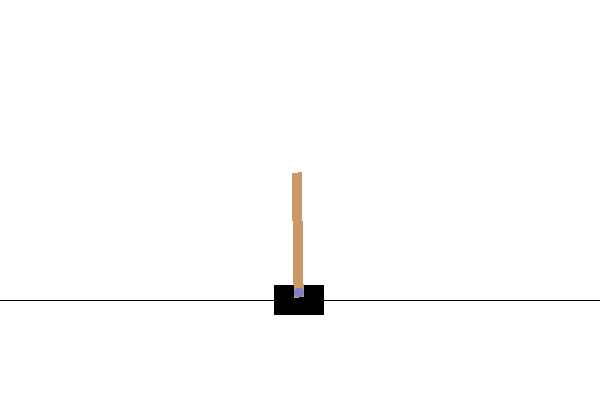

In [5]:
env = gym.make('CartPole-v0')
RenderWrapper.register(env, force_gif=True)

for episode_index in range(5):
    observation = env.reset()
    done = False

    for t in range(70):
        env.render_wrapper.render()

        if not done:
            print(observation)
        else:
            print("x", end="")
        
        ### BEGIN SOLUTION ###

        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)

        ### END SOLUTION ###

    print()
    env.close()

env.render_wrapper.make_gif("ex1random")

## Exercise 2: Implement a sigmoid policy

As the number of actions is $2$ (push the cart to the left or push it to the right), one can see the problem of controlling the Cart Pole as a binary classification problem.
Binary classification can be easily solved thanks to logistic regression which transforms the classification problem into a regression problem using the sigmoid function.

**Task 1**: Implement the `sigmoid` function defined by:

$$\sigma(x) = \frac{1}{1+e^{-x}}.$$

In [6]:
def sigmoid(x):
    ### BEGIN SOLUTION ###
    return 1.0 / (1.0 + np.exp(-x))
    ### END SOLUTION ###

**Task 2**: Complete the `logistic_regression` function that implements the logistic regression. This function returns the probability to draw action 1 ("push right") w.r.t the parameter vector $\theta$ and the input vector $s$ (the 4-dimension state vector).

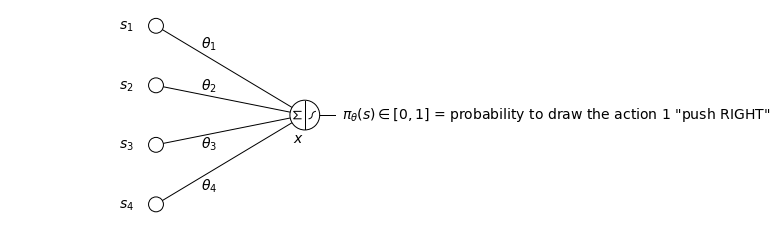

In [7]:
plot_logistic_regression_fig()

In [8]:
def logistic_regression(s, theta):
    ### BEGIN SOLUTION ###
    prob_push_right = sigmoid(np.dot(s, np.transpose(theta)))
    ### END SOLUTION ###

    return prob_push_right

**Task 3**: Complete the `draw_action` function that draw an action according to current policy i.e. that select the *RIGHT* action with probability $\sigma(\theta^\top s)$, where $\theta$ is the parameter vector and $s$ is the 4-dimension state vector.

In [9]:
def draw_action(s, theta):
    prob_push_right = logistic_regression(s, theta)

    ### BEGIN SOLUTION ###

    r = np.random.rand()
    if r < prob_push_right:
        return 1
    else:
        return 0

    ### END SOLUTION ###

## Exercise 3: Compute $\nabla_{\theta} \log \pi_\theta (s,a)$

Verify that, for a sigmoid policy:
- $\nabla_\theta \log \pi_\theta (s,\text{RIGHT}) = \pi_\theta (s, \text{LEFT}) \times s$
- $\nabla_\theta \log \pi_\theta (s,\text{LEFT}) = - \pi_\theta (s, \text{RIGHT}) \times s$ 

### Answer

First, let's define $\pi(s, RIGHT)$ and $\pi(s, LEFT)$:
- $\pi(s, RIGHT) = \sigma(s^\top \theta)$
- $\pi(s, LEFT) = 1 - \sigma(s^\top \theta)$

Then, let's compute the derivative of the sigmoid function:
$$
\sigma'(x) = \sigma(x) (1 - \sigma(x))
$$

1. Compute $\nabla_\theta \log \pi_\theta (s,\text{RIGHT})$:

\begin{align}
\nabla_\theta \log \pi_\theta (s,\text{RIGHT})
&= \nabla_\theta \log \sigma(s^\top \theta) \\
&= \frac{1}{\sigma(s^\top \theta)} \nabla_\theta \sigma(s^\top \theta) \\
&= \frac{1}{\sigma(s^\top \theta)} \sigma(s^\top \theta) (1 - \sigma(s^\top \theta)) ~ s \\
&= (1 - \sigma(s^\top \theta)) ~ s \\
&= \pi_\theta(s, \text{LEFT}) \times s \\
\end{align}

2. Compute $\nabla_\theta \log \pi_\theta (s,\text{LEFT})$:

\begin{align}
\nabla_\theta \log \pi_\theta (s,\text{LEFT})
&= \nabla_\theta \log (1 - \sigma(s^\top \theta)) \\
&= \frac{1}{1 - \sigma(s^\top \theta)} \nabla_\theta (1 - \sigma(s^\top \theta)) \\
&= \frac{-1}{1 - \sigma(s^\top \theta)} \sigma(s^\top \theta) (1 - \sigma(s^\top \theta)) ~ s \\
&= -\sigma(s^\top \theta) ~ s \\
&= -\pi_\theta(s, \text{RIGHT}) \times s \\
\end{align}

## Exercise 4: Implement REINFORCE

Fill the following cells to implement the REINFORCE algorithm (defined in the introduction of this notebook).

In [10]:
ENV_NAME = "CartPole-v0"

# Since the goal is to attain an average return of 195, horizon should be larger than 195 steps (say 300 for instance)
EPISODE_DURATION = 300

ALPHA_INIT = 0.1
SCORE = 195.0
NUM_EPISODES = 100
LEFT = 0
RIGHT = 1

VERBOSE = True

**Task 1**: Implement the `play_one_episode` function that plays an episode with the given policy $\pi_\theta$ (for fixed horizon $H$) and returns its rollouts.

In [11]:
# Generate an episode
def play_one_episode(env, theta, max_episode_length=EPISODE_DURATION, render=False):
    s_t = env.reset()

    episode_states = []
    episode_actions = []
    episode_rewards = []
    episode_states.append(s_t)

    for t in range(max_episode_length):

        if render:
            env.render_wrapper.render()

        ### BEGIN SOLUTION ###

        a_t = draw_action(s_t, theta)
        s_t, r_t, done, info = env.step(a_t)

        ### END SOLUTION ###

        episode_states.append(s_t)
        episode_actions.append(a_t)
        episode_rewards.append(r_t)

        if done:
            break

    return episode_states, episode_actions, episode_rewards

**Task 2**: Implement the `score_on_multiple_episodes` function that test the given policy $\pi_\theta$ on `num_episodes` episodes (for fixed horizon $H$) and returns:
- `success`: `True` if the agent got an average reward greater or equals to 195 over 100 consecutive trials, `False` otherwise
- `num_success`: the number of episodes where the agent got an average reward greater or equals to 195
- `average_return`: the average reward on the `num_episodes` episodes

In [12]:
def score_on_multiple_episodes(env, theta, score=SCORE, num_episodes=NUM_EPISODES, max_episode_length=EPISODE_DURATION, render=False):
    
    ### BEGIN SOLUTION ###
    
    num_success = 0
    average_return = 0
    num_consecutive_success = [0]

    for episode_index in range(num_episodes):
        _, _, episode_rewards = play_one_episode(env, theta, max_episode_length, render)

        total_rewards = sum(episode_rewards)

        if total_rewards >= score:
            num_success += 1
            num_consecutive_success[-1] += 1
        else:
            num_consecutive_success.append(0)

        average_return += (1.0 / num_episodes) * total_rewards

        if render:
            print("Test Episode {0}: Total Reward = {1} - Success = {2}".format(episode_index,total_rewards,total_rewards>score))

    if max(num_consecutive_success) >= 100:    # MAY BE ADAPTED TO SPEED UP THE LERNING PROCEDURE
        success = True
    else:
        success = False
        
    ### END SOLUTION ###

    return success, num_success, average_return

**Task 3**: Implement the `compute_policy_gradient` function that returns Policy Gradient for a given episode: policy gradient = $\sum_{t=1}^H \nabla_\theta \log \pi_\theta(s_t,a,_t) R_t$.

In [13]:
# Returns Policy Gradient for a given episode
def compute_policy_gradient(episode_states, episode_actions, episode_rewards, theta):

    ### BEGIN SOLUTION ###

    H = len(episode_rewards)
    PG = 0

    for t in range(H):

        prob_push_right = logistic_regression(episode_states[t], theta)
        a_t = episode_actions[t]
        R_t = sum(episode_rewards[t::])
        if a_t == LEFT:
            g_theta_log_pi = - prob_push_right * episode_states[t] * R_t
        else:
            prob_push_left = (1 - prob_push_right)
            g_theta_log_pi = prob_push_left * episode_states[t] * R_t

        PG += g_theta_log_pi

    ### END SOLUTION ###

    return PG

**Task 4**: Implement the `train` function that updates $\theta$ parameters with gradient ascent until the agent got an average reward greater or equals to 195 over 100 consecutive trials.

In [14]:
# Train the agent got an average reward greater or equals to 195 over 100 consecutive trials
def train(env, theta_init, max_episode_length = EPISODE_DURATION, alpha_init = ALPHA_INIT):

    theta = theta_init
    episode_index = 0
    average_returns = []

    success, _, R = score_on_multiple_episodes(env, theta)
    average_returns.append(R)

    # Train until success
    while (not success):

        ### BEGIN SOLUTION ###

        # Rollout
        episode_states, episode_actions, episode_rewards = play_one_episode(env, theta, max_episode_length)

        # Schedule step size
        #alpha = alpha_init
        alpha = alpha_init / (1 + episode_index)

        # Compute gradient
        PG = compute_policy_gradient(episode_states, episode_actions, episode_rewards, theta)

        # Do gradient ascent
        theta += alpha * PG

        # Test new policy
        success, _, R = score_on_multiple_episodes(env, theta, render=False)

        # Monitoring
        average_returns.append(R)

        episode_index += 1

        if VERBOSE:
            print("Episode {0}, average return: {1}".format(episode_index, R))

        ### END SOLUTION ###

    return theta, episode_index, average_returns

### Train the agent

In [15]:
#np.random.seed(1234)
env = gym.make(ENV_NAME)
RenderWrapper.register(env, force_gif=True)
#env.seed(1234)

In [16]:
dim = env.observation_space.shape[0]

# Init parameters to random
theta_init = np.random.randn(1, dim)

# Train the agent
theta, i, average_returns = train(env, theta_init)

print("Solved after {} iterations".format(i))

Episode 1, average return: 77.19000000000003
Episode 2, average return: 79.61000000000003
Episode 3, average return: 90.33999999999996
Episode 4, average return: 91.34000000000003
Episode 5, average return: 86.89999999999999
Episode 6, average return: 90.42000000000002
Episode 7, average return: 84.56999999999998
Episode 8, average return: 84.78000000000002
Episode 9, average return: 91.21000000000001
Episode 10, average return: 97.89000000000001
Episode 11, average return: 95.69000000000003
Episode 12, average return: 97.66999999999999
Episode 13, average return: 94.61999999999998
Episode 14, average return: 94.04999999999998
Episode 15, average return: 97.31000000000003
Episode 16, average return: 97.69000000000005
Episode 17, average return: 95.53000000000004
Episode 18, average return: 95.20000000000005
Episode 19, average return: 95.23999999999998
Episode 20, average return: 93.62
Episode 21, average return: 99.31
Episode 22, average return: 94.27000000000004
Episode 23, average r

### Test final policy

In [ ]:
score_on_multiple_episodes(env, theta, num_episodes=10, render=True)
env.render_wrapper.make_gif("ex4")

Test Episode 0: Total Reward = 200.0 - Success = True
Test Episode 1: Total Reward = 200.0 - Success = True
Test Episode 2: Total Reward = 200.0 - Success = True
Test Episode 3: Total Reward = 200.0 - Success = True
Test Episode 4: Total Reward = 200.0 - Success = True
Test Episode 5: Total Reward = 200.0 - Success = True


### Display the evolution of the average reward w.r.t. PG iterations

In [ ]:
# Show training curve
plt.plot(range(len(average_returns)),average_returns)
plt.title("Average reward on 100 episodes")
plt.xlabel("Training Steps")
plt.ylabel("Reward")

plt.show()

env.close()

## Bonus: solve more challenging environments using Stable-Baselines

Knowing main Reinforcement Learning concepts is important to solve RL problems, but being able to quickly solve problems reusing robust and proven implementations of RL algorithms is important too.

Stable-Baselines is a Python library that provide state of the art ready to use RL algorithms.

The following notebook provides an example of how to use it with Google Colab: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2022/blob/main/lab7_rl3_reinforce_baselines.ipynb